In [1]:
class args:
  out_FN = 'AAA.mol2'
  SMILES = 'CC(=O)NCCC1=CNc2c1cc(OC)cc2' # 'N[C@@H](C)C(=O)O'
  UseOpenEye = 'Y'

print 'Generating %s based on %s'%(args.out_FN, args.SMILES)

import os, inspect
dirs = {}
dirs['script'] = os.path.dirname(os.path.abspath(\
  inspect.getfile(inspect.currentframe())))
execfile(os.path.join(dirs['script'],'_external_paths.py'))
command_paths = findPaths(['balloon','chimera'])
threeD_FN = os.path.join('3D', os.path.basename(args.out_FN))

Generating AAA.mol2 based on CC(=O)NCCC1=CNc2c1cc(OC)cc2


In [2]:
from openeye import oechem
from openeye import oequacpac

# Create a OpenEye molecule object from the SMILES string
mol = oechem.OEGraphMol()
if not oechem.OESmilesToMol(mol, args.SMILES):
  raise Exception('Invalid SMILES string', args.SMILES)
  
oechem.OECanonicalOrderAtoms(mol)
oechem.OECanonicalOrderBonds(mol)

# Assign a reasonable protomer
if not oequacpac.OEGetReasonableProtomer(mol):
  raise Exception('Failed to get a reasonable protomer at pH 7.4')
  
oechem.OEAssignAromaticFlags(mol, oechem.OEAroModelOpenEye)
oechem.OEAddExplicitHydrogens(mol)

smi = oechem.OECreateSmiString(mol, oechem.OESMILESFlag_Canonical)
print 'The canonical SMILES for a reasonably protonated state is', smi

The canonical SMILES for a reasonably protonated state is CC(=O)NCCc1c[nH]c2c1cc(cc2)OC


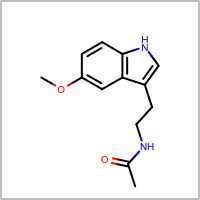

In [3]:
import oenotebook as oenb

oenb.draw_mol(mol)

In [4]:
  # Generate conformations
  from openeye import oeomega

  mol_multiconf = oechem.OEMol(mol)

  omega = oeomega.OEOmega()
  # These parameters were chosen to match http://docs.eyesopen.com/toolkits/cookbook/python/modeling/am1-bcc.html
  omega.SetMaxConfs(800)
  omega.SetIncludeInput(False)
  omega.SetCanonOrder(False)

  omega.SetStrictStereo(True)
  omega.SetStrictAtomTypes(True)

  omega.SetSampleHydrogens(True)  # Word to the wise: skipping this step can lead to significantly different charges!
  omega.SetEnergyWindow(15.0)
  omega.SetRMSThreshold(1.0)  # Word to the wise: skipping this step can lead to significantly different charges!

  omega(mol_multiconf)  # generate conformation

<oeomega.OEOmega; proxy of <Swig Object of type 'OEConfGen::OEOmega *' at 0x1092595d0> >
<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x1092594e0> >


True

In [5]:
# Generate am1bcc partial charges
oequacpac.OEAssignPartialCharges(mol_multiconf, oequacpac.OECharges_AM1BCCSym)

# Get total charge
conf = mol_multiconf.GetConf(oechem.OEHasConfIdx(0))
absFCharge = 0
sumFCharge = 0
sumPCharge = 0.0
for atm in mol_multiconf.GetAtoms():
    sumFCharge += atm.GetFormalCharge()
    absFCharge += abs(atm.GetFormalCharge())
    sumPCharge += atm.GetPartialCharge()
oechem.OEThrow.Info("%s: %d formal charges give total charge %d ; Sum of Partial Charges %5.4f"
                         % (mol_multiconf.GetTitle(), absFCharge, sumFCharge, sumPCharge))

# Output file
ofs = oechem.oemolostream(args.out_FN)
ofs.SetFormat(oechem.OEFormat_MOL2H)
oechem.OEWriteMolecule(ofs, conf)

: 0 formal charges give total charge 0 ; Sum of Partial Charges 0.0000


0